<a href="https://colab.research.google.com/github/ricardofelippe/Mapa/blob/main/Explorando_as_despesas_do_governo_federal_via_API_%5BEscola_de_Dados%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gastos públicos federais via API - Despesas e contratos

Este tutorial é baseado no workshop realizado por Fernanda Campagnucci, diretora-executiva da Open Knowledge Brasil, no Coda.Br 2019. O notebook foi atualizado por Adriano Belisário em setembro de 2020.

## API x Bases de Dados
---

Quem não tem fluência em programação, pode pasar por uma certa curva de aprendizagem para começar a usar APIs (*Application Programming Interface*). Em alguns casos, porém, você pode ganhar muito tempo se optar por consumir os dados via API, mesmo que demore mais para criar seu código pela primeira vez.

Confira abaixo uma comparação sobre as duas formas de acessar os dados. Mas atenção: essa comparação não é geral, ela se aplica especificamente ao Portal da Transparência do Governo Federal e à maneira como os dados estão disponibilizados hoje.

| Situação                       |   API           | Download de CSV  |
| :-------------                 | :-------------  | :------------- |
| Preciso de uma série histórica grande| +               | +++++          |
| Não faço pauta desse tema com frequência | ++               | +++++|
| Quero monitorar um assunto/cnpj/órgão etc | +++++               | +          |
| Quero conectar em um site ou visualização | ++++               | ++      |
| *Que outras situações ocorrem a vocês?* |               |      |




### Onde encontrar?

Para conhecer os dados disponíveis, sistema de origem, órgão responsável, periodicidade e data de atualização do Portal (download e API):

http://transparencia.gov.br/origem-dos-dados

- **Acesso via API**

http://www.transparencia.gov.br/swagger-ui.html

O Swagger é uma feramenta que documenta e permite explorar o conteúdo. Iremos falar mais sobre ela abaixo.

- **Bases para download**

http://transparencia.gov.br/download-de-dados

https://brasil.io/dataset/gastos-diretos/gastos (coletado e tratado por Álvaro Justen (Turicas) - tenha atenção para as datas de atualização no site)


## Planejamento e orçamento público
---

Agora que já sabemos onde encontrar os dados, vamos revisar algumas noções básicas sobre orçamento público, a começar com o diagrama abaixo, que é bastante didático e representa as etapas de elaboração das políticas públicas.


![O governo define prioridades que originam programas estruturados em ações, que objetivam resultados e metas, atingidos por meio da aquisição de bens e serviços, que são previstas em dotações orçamentárias. Fonte: Adaptado da aula da profa. Ursula Peres e Fabio Pereira (2016)](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento1-e1574301837420.png)




### Princípios do Orçamento

O orçamento público deve observar um conjunto de princípios presentes na Constituição e nas leis que regem o processo orçamentário no Brasil, em especial a Lei nº 4.320/1964 e a Lei nº 101/2000.

![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento2.png)


### Classificações de Despesa

Cada despesa do governo federal é classificada de acordo com os seguintes critérios.

![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento3.png)

Cada item da segunda coluna é representada por um código, que traz um identificador relacionado à despesa. Vejamos o exemplo abaixo.


![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/Screen-Shot-2019-11-23-at-00.59.24.png)

Vamos fazer nosso primeiro exercício no Swagger? Com a [chave de acesso (**clique aqui para criar uma - esta etapa é fundamental para os próximos passos**)](http://www.portaldatransparencia.gov.br/api-de-dados/cadastrar-email) em mãos, entre na página a seguir e role a página até encontrar o formulário abaixo, que irá permitir consultarmos as despesas do Governo Federal de acordo com a função (o item verde escuro na ilustração acima): http://www.transparencia.gov.br/swagger-ui.html#!/Despesas32P250blicas/despesasPorFuncaoUsingGET

![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento6.png)

Preencha os campos com as informações acima e clique no botão 'Tente agora!'. Você deve ver o resultado em formato JSON, como na imagem abaixo. Além disso, preste atenção também no campo 'URL requisição'. Iremos utilizá-lo posteriormente, quando incorporarmos a URL da consulta desejada no código.

![alt text](http://umdadoamais.com/wp-content/uploads/2019/11/tutorial_orcamento7.png)

Para fins comparativos, imagine a mesma consulta, mas utilizando o download dos arquivos CSVs, ao invés da API. Neste caso, o trabalho seria bem maior. De forma resumida, seria preciso baixar cada mês e juntar todas bases, depois filtrar os valores desejados nas colunas e, enfim, somar os números registrados nos campos de valores empenhado, liquidado e pago.

## Mais referências
Para mais detalhes, vale a pena conferir esta documentação sobre o orçamento federal, que é frequentemente atualizada pelo governo no [Manual Técnico do Orçamento Federal](https://www1.siop.planejamento.gov.br/mto/lib/exe/fetch.php/mto2020:mto2020-versao5.pdf).(MTO 2020)


Há também um material do INESC, que explica o orçamento e sua relação com direitos humanos, na [Cartilha Orçamento e Direitos](https://www.inesc.org.br/orcamento-direitos-2018-2/) (2018).

# Acessando a API

---



Agora que já compreendemos o básico sobre como as despesas do governo federal são registradas, vamos colocar a mão na massa rodando alguns códigos em Python.

Iremos começar importando os pacotes que iremos utilizar.

Clique no botão de "Play" abaixo para executar o código. Se nenhum erro aparecer, então, deu tudo certo :)

In [1]:
import pandas as pd
import requests
import json
import numpy as np
from IPython.display import Image


### Despesas

Nosso primeiro exercício será coletar uma série histórica de despesas do Ministério do Meio Ambiente (um órgão superior, identificado pelo número 44000), utilizando um loop que irá consultar uma certa URL para cada ano entre 2016 e 2020.

Para descobrir o identificador de outros órgãos, você pode consultar o item 8.2 do [Manual Técnico do Orçamento](https://www1.siop.planejamento.gov.br/mto/lib/exe/fetch.php/mto2020:mto2020-versao5.pdf#page=153).

E é fundamental inserir uma [chave válida](http://www.portaldatransparencia.gov.br/api-de-dados/cadastrar-email) na variável abaixo.


In [2]:
# Troque os caracteres abaixo por uma chave válida, criada com seu email, usando o endereço abaixo
# http://www.portaldatransparencia.gov.br/api-de-dados/cadastrar-email
minha_chave = '3fd8bbb6a046fd05f768fb0b7fbefbb3'

# para conseguir acessar a API, precisamos incluir no cabeçalho da requisição a nossa chave, que definimos anteriormente. Não é necessário alterar essa variável.
chave = {'chave-api-dados':minha_chave}

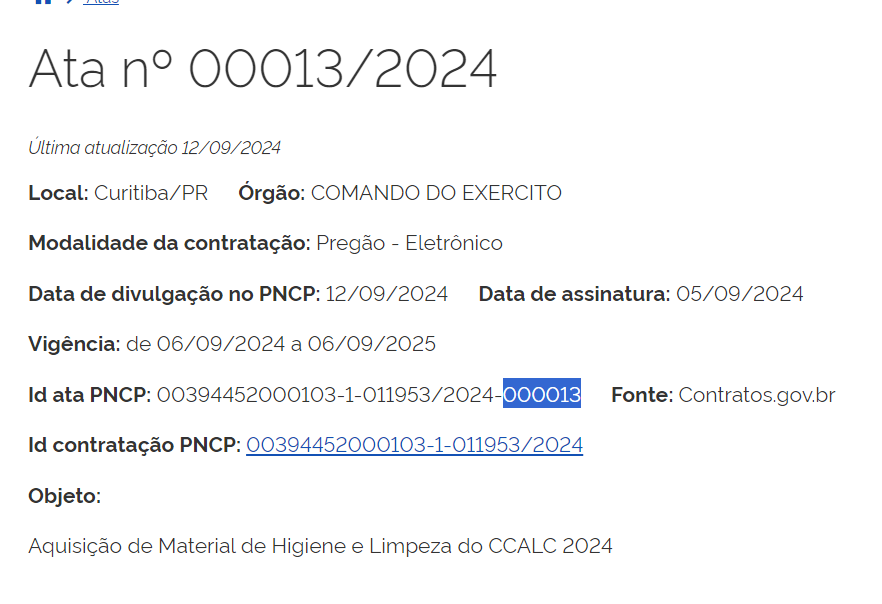

In [9]:
Image("ExemploAta.png")


In [6]:
serie_orgao = []

# O loop abaixo irá tomar como ponto de partido o intervalo de números entre 2019 e e 2019, incluindo estes dois.
url = f'https://pncp.gov.br/api/pncp/v1/orgaos/00394452000103/compras/2024/011953/atas/000003/arquivos'
    # esta URL foi gerada a partir da consulta por órgão no swagger

    # aqui, fazemos a consulta e obtemos o resultado para cada ano em JSON
r_orgao = requests.get(url,headers=chave).json()

    # e aqui juntamos os resultados de cada ano em uma série histórica do órgão


In [12]:
r_orgao[0]['url']



'https://pncp.gov.br/pncp-api/v1/orgaos/00394452000103/compras/2024/011953/atas/000003/arquivos/1'

In [ ]:
serie_orgao = []

# O loop abaixo irá tomar como ponto de partido o intervalo de números entre 2019 e e 2019, incluindo estes dois.
url = f'https://pncp.gov.br/api/pncp/v1/orgaos/00394452000103/compras/2024/011953/atas/000013/arquivos'
    # esta URL foi gerada a partir da consulta por órgão no swagger

    # aqui, fazemos a consulta e obtemos o resultado para cada ano em JSON
r_orgao = requests.get(url,headers=chave).json()

    # e aqui juntamos os resultados de cada ano em uma série histórica do órgão


In [17]:
r_orgao[0]['url']


'https://pncp.gov.br/pncp-api/v1/orgaos/00394452000103/compras/2024/011953/atas/000003/arquivos/1'

In [70]:
vigenciaInicio=list(map(lambda x:x["vigenciaInicio"],r_orgao))

In [71]:
anoAta=list(map(lambda x:x["anoAta"],r_orgao))
cancelado=list(map(lambda x:x["cancelado"],r_orgao))
vigenciaInicio=list(map(lambda x:x["vigenciaInicio"],r_orgao))
vigenciaFim=list(map(lambda x:x["vigenciaFim"],r_orgao))
usuario=list(map(lambda x:x["usuario"],r_orgao))
objetoContratacao=list(map(lambda x:x["objetoContratacao"],r_orgao))
codigoUnidadeOrgao=list(map(lambda x:x["codigoUnidadeOrgao"],r_orgao))
nomeUnidadeOrgao=list(map(lambda x:x["nomeUnidadeOrgao"],r_orgao))


data = pd.DataFrame([anoAta, cancelado, vigenciaInicio,vigenciaFim,usuario,objetoContratacao,codigoUnidadeOrgao,nomeUnidadeOrgao]) # Each list would be added as a row
data = data.transpose() 
data.columns = ['anoAta', 'cancelado', 'vigenciaInicio',"vigenciaFim","usuario","objetoContratacao","codigoUnidadeOrgao","nomeUnidadeOrgao"]
 # Rename the

data.to_excel("output.xlsx",sheet_name='Sheet_name_1')  

In [55]:
print(type(vigenciaInicio))

<class 'list'>


In [52]:
vigenciaInicio

['2023-01-12',
 '2023-01-04',
 '2023-01-10',
 '2023-01-23',
 '2023-02-09',
 '2023-02-10',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-19',
 '2023-03-09',
 '2023-03-13',
 '2023-04-24',
 '2023-04-24',
 '2023-04-24',
 '2023-04-24',
 '2023-04-24',
 '2023-04-24',
 '2023-04-24',
 '2023-04-24',
 '2023-04-24',
 '2023-04-26',
 '2023-04-26',
 '2023-04-26',
 '2023-04-26',
 '2023-04-26',
 '2023-04-26',
 '2023-04-26',
 '2023-04-18',
 '2023-04-18',
 '2023-04-18',
 '2023-04-18',
 '2023-04-18',
 '2023-04-18',
 '2023-04-18',
 '2023-04-18',
 '2023-04-18',
 '2023-05-04',
 '2023-05-17',
 '2023-05-17',
 '2023-05-17',
 '2023-05-17',
 '2023-05-17',
 '2023-05-17',
 '2023-05-17',
 '2023-05-17',
 '2023-05-17',
 '2023-05-22',
 '2023-05-22',
 '2023-03-20',
 '2023-03-20',
 '2023-03-20',
 '2023-04-27',
 '2023-04-27',
 '2023-04-27',
 '2023-04-27',
 '2023-05-

In [44]:
x

[2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,
 2023,

In [42]:
r_orgao.keys()

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
temp=pd.DataFrame.from_dict(r_orgao)
print(temp)

In [25]:
# Converter o JSON em DataFrame
df = pd.json_normalize(json_data['data'])

# Exibir o DataFrame
print(df)

                 numeroControlePNCPAta numeroAtaRegistroPreco anoAta  \
0  15126437000143-1-000989/2023-000025                  00463   2023   
1  35840659000130-1-000033/2023-000006                  00007   2023   

       numeroControlePNCPCompra  cancelado dataCancelamento dataAssinatura  \
0  15126437000143-1-000989/2023      False             None     2023-08-09   
1  35840659000130-1-000033/2023      False             None     2023-08-07   

  vigenciaInicio vigenciaFim dataPublicacaoPncp  ...           usuario  \
0     2023-08-10  2024-08-10         2023-08-10  ...  Contratos.gov.br   
1     2023-08-08  2024-08-07         2023-08-10  ...  Contratos.gov.br   

                                   objetoContratacao       cnpjOrgao  \
0  Aquisição de medicamentos de uso geral e de gr...  15126437000143   
1  Aquisição de Sistema de Registro de Preço para...  35840659000130   

                                     nomeOrgao cnpjOrgaoSubrogado  \
0  EMPRESA BRASILEIRA DE SERVIÇOS HOSPI

In [16]:
# Converter o JSON em DataFrame
df = pd.json_normalize(json_data['data'])

# Exibir o DataFrame
print(df)

                                                data  totalRegistros  \
0  [{'numeroControlePNCPAta': '15126437000143-1-0...          204546   

   totalPaginas  numeroPagina  paginasRestantes  empty  
0           410             3               407  False  


In [ ]:
serie_orgao = []

# O loop abaixo irá tomar como ponto de partido o intervalo de números entre 2019 e e 2019, incluindo estes dois.

for ano in range(2016, 2019):

    url = f'http://www.transparencia.gov.br/api-de-dados/despesas/por-orgao?ano={ano}&orgaoSuperior=44000&pagina=1'
    # esta URL foi gerada a partir da consulta por órgão no swagger

    # aqui, fazemos a consulta e obtemos o resultado para cada ano em JSON
    r_orgao = requests.get(url, verify=True,headers=chave).json()

    # e aqui juntamos os resultados de cada ano em uma série histórica do órgão
    serie_orgao = serie_orgao + r_orgao

In [28]:
# Transformamos os resultados - que vieram em formato JSON - em um dataframe
df_serie_orgao = pd.DataFrame(r_orgao)

# E agora visualizamos os últimos 5 registros desta base de dados
#df_serie_orgao.tail(5)
print(df_serie_orgao)

                                                  data  totalRegistros  \
0    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
1    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
2    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
3    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
4    {'numeroControlePNCPAta': '01612781000138-1-00...          204882   
..                                                 ...             ...   
495  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   
496  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   
497  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   
498  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   
499  {'numeroControlePNCPAta': '15126437000143-1-00...          204882   

     totalPaginas  numeroPagina  paginasRestantes  empty  
0             410             1               409  F

Fácil, não? Agora, vamos agrupar por órgao e comparar ano a ano. Para isso, usaremos função parecida com a "tabela dinâmica" dos editores de planilha. Nossas colunas serão os anos e cada linha será um órgão do Ministério do Meio Ambiente. Os valores serão somados de acordo com o ano e órgão.

In [ ]:
df_por_orgao = pd.pivot_table(df_serie_orgao,
                              values='liquidado',
                              index=['orgao'],
                              columns='ano',
                              aggfunc=np.sum).sort_values(by='orgao', ascending=False)

df_por_orgao

## Fazendo buscas mais específicas
Agora, vamos coletar dados de execução orçamentária da subfunção "controle ambiental" (identificada pelo código 542). Como você viu, tudo começa com a definição da URL e dos parâmetros e códigos que iremos passar em nossa consulta. Vamos definir manualmente cada um dos parâmetros de nossa consulta à API.

In [ ]:
# Vamos definir os termos de nossa consulta

ano=2019 # você pode mudar o ano de acordo com a necessidade
subfuncao=542 #código referente a "controle ambiental"

In [ ]:
url = f'http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano={ano}&subfuncao={subfuncao}'
# a base desta URL foi gerada no Swagger. com o comando acima, estamos "colando" os valores definidos anteriormente nas partes adequadas da URL

url

'http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano=2019&subfuncao=542'

In [ ]:
page = 1
registro = requests.get(url+f'&pagina={page}',
                           verify=True,headers=chave).json()

registro

[{'acao': 'ESTUDOS DE IMPACTO AMBIENTAL PARA PROJETOS DE INFRAESTRUTURA DE TRANSPORTES',
  'ano': 2019,
  'codigoAcao': '6241',
  'codigoFuncao': '26',
  'codigoPrograma': '0225',
  'codigoSubfuncao': '542',
  'empenhado': '0,00',
  'funcao': 'Transporte',
  'liquidado': '0,00',
  'pago': '0,00',
  'programa': 'GESTÃO DA POLÍTICA DOS TRANSPORTES',
  'subfuncao': 'Controle ambiental'},
 {'acao': 'POLITICAS E ESTRATEGIAS DE PREVENCAO E CONTROLE DO DESMATAMENTO E DE MANEJO E RECUPERACAO FLORESTAL NO AMBITO DA UNIAO, ESTADOS E MUNICIPIOS',
  'ano': 2019,
  'codigoAcao': '20VU',
  'codigoFuncao': '18',
  'codigoPrograma': '2050',
  'codigoSubfuncao': '542',
  'empenhado': '303.989,98',
  'funcao': 'Gestão ambiental',
  'liquidado': '298.720,09',
  'pago': '298.720,09',
  'programa': 'MUDANCA DO CLIMA',
  'subfuncao': 'Controle ambiental'},
 {'acao': 'IMPLEMENTAÇÃO DA POLÍTICA NACIONAL DE RESÍDUOS SÓLIDOS',
  'ano': 2019,
  'codigoAcao': '2E42',
  'codigoFuncao': '18',
  'codigoPrograma': '8

Temos o nosso resultado! Mas... precisamos fazer uma iteração para coletar todas as páginas, não apenas a primeira.

In [ ]:
# Vamos definir aqui a página inicial e o tamanho do registro que obtemos da API. Se ele for zero, a iteração irá parar.
page = 1
tamanho = len(registro)

# E vamos armazenar as informações de todas as páginas chamando a de "dados"
dados = []

# Aqui a iteração que irá percorrer as páginas
while(tamanho>0):
    print('Baixando a página', page, ' do link:', url+f'&pagina={page}')
    registro = requests.get(url+f'&pagina={page}',headers=chave).json()
    tamanho = len(registro)
    # Se a resposta for válida, vamos juntar o registro da página atual com os dados já coletados
    if tamanho > 0:
      dados = dados + registro
      page = page + 1
      print('O tamanho da última resposta foi',tamanho,'. Iremos seguir em frente!')
    else:
      print('A última requisição veio vazia. Paramos por aqui.')


Baixando a página 1  do link: http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano=2019&subfuncao=542&pagina=1
O tamanho da última resposta foi 15 . Iremos seguir em frente!
Baixando a página 2  do link: http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano=2019&subfuncao=542&pagina=2
O tamanho da última resposta foi 8 . Iremos seguir em frente!
Baixando a página 3  do link: http://www.transparencia.gov.br/api-de-dados/despesas/por-funcional-programatica?ano=2019&subfuncao=542&pagina=3
A última requisição veio vazia. Paramos por aqui.


In [ ]:
# Vamos transformar o JSON em um dataframe do pandas
df = pd.DataFrame(dados)

In [ ]:
# Vamos conferir os 5 últimos registros (útil para checar se todos os dados foram importados)
df.tail(5)

,ano,funcao,codigoFuncao,subfuncao,codigoSubfuncao,programa,codigoPrograma,acao,codigoAcao,empenhado,liquidado,pago
18,2019,Gestão ambiental,18,Controle ambiental,542,RESÍDUOS SÓLIDOS URBANOS,8007,IMPLEMENTAÇÃO DA POLÍTICA NACIONAL DE RESÍDUOS...,2E42,"0,00","0,00","0,00"
19,2019,Gestão ambiental,18,Controle ambiental,542,MUDANCA DO CLIMA,2050,POLITICAS E ESTRATEGIAS DE PREVENCAO E CONTROL...,20VU,"303.989,98","298.720,09","298.720,09"
20,2019,Ciência e Tecnologia,19,Controle ambiental,542,POLITICA NUCLEAR,2059,PROTECAO RADIOLOGICA,215M,"0,00","0,00","0,00"
21,2019,Gestão ambiental,18,Controle ambiental,542,"OCEANOS, ZONA COSTEIRA E ANTARTICA",2046,POLITICAS PARA A GESTAO AMBIENTAL E TERRITORIA...,20W0,"945.829,34","274.555,79","274.555,79"
22,2019,Gestão ambiental,18,Controle ambiental,542,MUDANCA DO CLIMA,2050,PREVENCAO E CONTROLE DE INCENDIOS FLORESTAIS N...,214M,"40.681.212,20","36.711.063,74","34.097.966,00"


Por fim, vamos agrupar os valores empenhados por programa e função. Para isso, precisaremos converter esta coluna para número.

In [ ]:
# Aqui vamos salvar nosso resultado como um CSV e reimportá-lo especificando que os números estão no formato brasileiro
df.to_csv('arquivo.csv')

In [ ]:
# Desabilita notação científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df = pd.read_csv('arquivo.csv', decimal=',', thousands='.')

In [ ]:
df_por_programa = pd.pivot_table(df,
                              values='empenhado',
                              index=['programa'],
                              columns='funcao',
                              aggfunc=np.sum)

df_por_programa

funcao,Ciência e Tecnologia,Defesa nacional,Energia,Gestão ambiental,Transporte
programa,,,,,
CONSERVACAO E USO SUSTENTAVEL DA BIODIVERSIDADE,nan,nan,nan,15175761.590,nan
DEFESA NACIONAL,nan,45589050.810,nan,nan,nan
"FLORESTAS, PREVENCAO E CONTROLE DO DESMATAMENTO E DOS INCEND",nan,nan,nan,0.000,nan
GESTÃO DA POLÍTICA DOS TRANSPORTES,nan,nan,nan,nan,0.000
MUDANCA DO CLIMA,3207569.920,nan,nan,81970404.360,nan
"OCEANOS, ZONA COSTEIRA E ANTARTICA",nan,nan,nan,945829.340,nan
PETROLEO E GAS,nan,nan,3569005.500,nan,nan
POLITICA NUCLEAR,0.000,nan,nan,nan,nan
PROGRAMA DE GESTAO E MANUTENCAO DO MINISTERIO DA INFRAESTRUT,nan,nan,nan,nan,0.000
